# Mateusz Styrc, ING, zaliczenie Bootcamp Datascience
## Zadanie Temat 2
Przewidywanie wzięcia pożyczki. Celem projektu jest zastosowanie modeli klasyfikacji (binarnej) do
przewidzenia czy pożyczka zostanie udzielona danemu klientowi z danymi parametrami wniosku.

In [1]:
# Link do danych: https://raw.githubusercontent.com/saimadhu-
# polamuri/DataHakthon3X/master/dataSet/Train.csv

# Opis danych (najdokładniejszy jaki istnieje): https://discuss.analyticsvidhya.com/t/hackathon-3-x-predict-
# customer-worth-for-happy-customer-bank/3802

# Zmienna celu (wypłacenie pożyczki): Disbursed
# Wymogi:
# ● Zmienna LoggedIn nie może być uwzględniona w modelowaniu - należy ją od razu wyrzucić ze
# zbioru.
# ● Nie usuwamy żadnych obserwacji - braki danych uzupełniamy w jakiś sposób.
# ● Wszelkie nieoczywiste przekształcenia danych należy opatrzyć uzasadnieniem dlaczego dokonujemy tego przekształcenia (np. robimy wykres i uzasadniamy wzięci logarytmu ze
# zmiennej tym, że rozkład jest skośny).
# ● Należy wykorzystać przynajmniej 3 metody klasyfikacji.
# ● Należy uwzględnić optymalizację modeli/pipelinów.
# ● Projekt musi być zakończony przejrzystym porównaniem przetestowanych rozwiązań modeli/pipelinów) w 
# postaci tabeli, gdzie jeden wiersz opisuje jedno rozwiązanie i jego wynik.

## Importy i bibl

In [1]:
import numpy as np
import pandas as pd 
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, Imputer
pd.options.display.max_columns = 200
pd.options.display.max_rows = 200

## wczytanie danych

In [2]:
# https://raw.githubusercontent.com/saimadhu-polamuri/DataHakthon3X/master/dataSet/Train.csv
    
cln_data_org = pd.read_csv('https://raw.githubusercontent.com/saimadhu-polamuri/DataHakthon3X/master/dataSet/Train.csv', encoding = "ISO-8859-1", engine='python')


In [3]:
cln_data = cln_data_org
# usuniecie ze zbioru LoggedIn
del cln_data["LoggedIn"]

In [4]:
# check czy zbior sie dobrze wczytal
cln_data.head(10)

,ID,Gender,City,Monthly_Income,DOB,Lead_Creation_Date,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Name,Salary_Account,Mobile_Verified,Var5,Var1,Loan_Amount_Submitted,Loan_Tenure_Submitted,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Filled_Form,Device_Type,Var2,Source,Var4,Disbursed
0,ID000002C20,Female,Delhi,20000,23-May-78,15-May-15,300000.0,5.0,0.0,CYBOSOL,HDFC Bank,N,0,HBXX,NaN,NaN,NaN,NaN,NaN,N,Web-browser,G,S122,1,0
1,ID000004E40,Male,Mumbai,35000,07-Oct-85,04-May-15,200000.0,2.0,0.0,TATA CONSULTANCY SERVICES LTD (TCS),ICICI Bank,Y,13,HBXA,200000.0,2.0,13.25,NaN,6762.90,N,Web-browser,G,S122,3,0
2,ID000007H20,Male,Panchkula,22500,10-Oct-81,19-May-15,600000.0,4.0,0.0,ALCHEMIST HOSPITALS LTD,State Bank of India,Y,0,HBXX,450000.0,4.0,NaN,NaN,NaN,N,Web-browser,B,S143,1,0
3,ID000008I30,Male,Saharsa,35000,30-Nov-87,09-May-15,1000000.0,5.0,0.0,BIHAR GOVERNMENT,State Bank of India,Y,10,HBXX,920000.0,5.0,NaN,NaN,NaN,N,Web-browser,B,S143,3,0
4,ID000009J40,Male,Bengaluru,100000,17-Feb-84,20-May-15,500000.0,2.0,25000.0,GLOBAL EDGE SOFTWARE,HDFC Bank,Y,17,HBXX,500000.0,2.0,NaN,NaN,NaN,N,Web-browser,B,S134,3,0
5,ID000010K00,Male,Bengaluru,45000,21-Apr-82,20-May-15,300000.0,5.0,15000.0,COGNIZANT TECHNOLOGY SOLUTIONS INDIA PVT LTD,HSBC,Y,17,HAXM,300000.0,5.0,13.99,1500.0,6978.92,N,Web-browser,B,S143,3,0
6,ID000011L10,Female,Sindhudurg,70000,23-Oct-87,01-May-15,6.0,5.0,0.0,CARNIVAL CRUISE LINE,Yes Bank,N,0,HBXX,NaN,NaN,NaN,NaN,NaN,N,Web-browser,B,S133,1,0
7,ID000012M20,Male,Bengaluru,20000,25-Jul-75,20-May-15,200000.0,5.0,2597.0,GOLDEN TULIP FLORITECH PVT. LTD,NaN,Y,3,HBXX,200000.0,5.0,NaN,NaN,NaN,N,Web-browser,B,S159,3,0
8,ID000013N30,Male,Kochi,75000,26-Jan-72,02-May-15,0.0,0.0,0.0,SIIS PVT LTD,State Bank of India,Y,13,HAXB,1300000.0,5.0,14.85,26000.0,30824.65,Y,Mobile,C,S122,5,0
9,ID000014O40,Female,Mumbai,30000,12-Sep-89,03-May-15,300000.0,3.0,0.0,SOUNDCLOUD.COM,Kotak Bank,Y,0,HBXC,300000.0,3.0,18.25,1500.0,10883.38,N,Web-browser,B,S133,1,0


In [5]:
# przygotowuje sobie pole z DOB (date of birth) kazdego wniosku i Lead creation date - byc moze pozniej mi sie przyda
cln_data["DOB"] = pd.to_datetime(cln_data.DOB)
cln_data["Lead_Creation_Date"] = pd.to_datetime(cln_data.Lead_Creation_Date)

In [6]:
# wyliczam liczbe lat wnioskujacego na moment kreacji leada
cln_data['Lead_Creation_year'] = cln_data.Lead_Creation_Date.apply(lambda x: x.year)
cln_data['DOB_year'] = cln_data.DOB.apply(lambda x: x.year)
cln_data['AGE_APPL'] = cln_data['Lead_Creation_year'] - cln_data['DOB_year']

# wyliczam czy nazwa pracodawcy jest dluga; potencjalnie potem tutaj chcialbym zrobic wieksze testowanie
cln_data['Empl_Name_len'] = cln_data['Employer_Name'].map(str).apply(len)


In [7]:
cln_data.head()

,ID,Gender,City,Monthly_Income,DOB,Lead_Creation_Date,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Name,Salary_Account,Mobile_Verified,Var5,Var1,Loan_Amount_Submitted,Loan_Tenure_Submitted,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Filled_Form,Device_Type,Var2,Source,Var4,Disbursed,Lead_Creation_year,DOB_year,AGE_APPL,Empl_Name_len
0,ID000002C20,Female,Delhi,20000,1978-05-23,2015-05-15,300000.0,5.0,0.0,CYBOSOL,HDFC Bank,N,0,HBXX,NaN,NaN,NaN,NaN,NaN,N,Web-browser,G,S122,1,0,2015,1978,37,7
1,ID000004E40,Male,Mumbai,35000,1985-10-07,2015-05-04,200000.0,2.0,0.0,TATA CONSULTANCY SERVICES LTD (TCS),ICICI Bank,Y,13,HBXA,200000.0,2.0,13.25,NaN,6762.9,N,Web-browser,G,S122,3,0,2015,1985,30,35
2,ID000007H20,Male,Panchkula,22500,1981-10-10,2015-05-19,600000.0,4.0,0.0,ALCHEMIST HOSPITALS LTD,State Bank of India,Y,0,HBXX,450000.0,4.0,NaN,NaN,NaN,N,Web-browser,B,S143,1,0,2015,1981,34,23
3,ID000008I30,Male,Saharsa,35000,1987-11-30,2015-05-09,1000000.0,5.0,0.0,BIHAR GOVERNMENT,State Bank of India,Y,10,HBXX,920000.0,5.0,NaN,NaN,NaN,N,Web-browser,B,S143,3,0,2015,1987,28,16
4,ID000009J40,Male,Bengaluru,100000,1984-02-17,2015-05-20,500000.0,2.0,25000.0,GLOBAL EDGE SOFTWARE,HDFC Bank,Y,17,HBXX,500000.0,2.0,NaN,NaN,NaN,N,Web-browser,B,S134,3,0,2015,1984,31,20


## funkcje wlasne - do automatyzacji i porownan

In [8]:
def rysuj_roc(fpr,tpr, auc):
    '''Funkcja do plotowania krzywej ROC      
       Pobiera: 
        fpr:numpy.array - false positive ratio obliczone z metody metrics.auc(),
        tpr:numpy.array - true positive ratio obliczone z metody metrics.auc()
    '''
    plt.plot(fpr, tpr, label='AUROC = %0.4f' %  auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Krzywa ROC')
    plt.legend(loc="lower right")
    plt.show()   

## wczytany zbior - podsumowanie

In [11]:
# statystyki zbioru, zaleznie od typu kolumn
for _type in cln_data.dtypes.unique():
        kolumny_typ = cln_data.select_dtypes(_type)
        print(str('podsumowanie dla atrybutow typ: ' +str(_type)))
        display(kolumny_typ.describe())

podsumowanie dla atrybutow typ: object


,ID,Gender,City,Employer_Name,Salary_Account,Mobile_Verified,Var1,Filled_Form,Device_Type,Var2,Source
count,87020,87020,86017,86949,75256,87020,87020,87020,87020,87020,87020
unique,87020,2,697,43567,57,2,19,2,2,7,30
top,ID063882A20,Male,Delhi,0,HDFC Bank,Y,HBXX,N,Web-browser,B,S122
freq,1,49848,12527,4914,17695,56481,59294,67530,64316,37280,38567


podsumowanie dla atrybutow typ: int64


,Monthly_Income,Var5,Var4,Disbursed,Lead_Creation_year,DOB_year,AGE_APPL,Empl_Name_len
count,8.702000e+04,87020.000000,87020.000000,87020.000000,87020.0,87020.000000,87020.000000,87020.000000
mean,5.884997e+04,4.961503,2.949805,0.014629,2015.0,1988.540784,26.459216,20.546530
std,2.177511e+06,5.670385,1.697720,0.120062,0.0,16.874958,16.874958,11.181013
min,0.000000e+00,0.000000,0.000000,0.000000,2015.0,1969.000000,-53.000000,1.000000
25%,1.650000e+04,0.000000,1.000000,0.000000,2015.0,1982.000000,26.000000,12.000000
50%,2.500000e+04,2.000000,3.000000,0.000000,2015.0,1986.000000,29.000000,20.000000
75%,4.000000e+04,11.000000,5.000000,0.000000,2015.0,1989.000000,33.000000,28.000000
max,4.445544e+08,18.000000,7.000000,1.000000,2015.0,2068.000000,46.000000,103.000000


podsumowanie dla atrybutow typ: datetime64[ns]


,DOB,Lead_Creation_Date
count,87020,87020
unique,11345,92
top,1980-11-11 00:00:00,2015-07-03 00:00:00
freq,306,2315
first,1969-01-01 00:00:00,2015-05-01 00:00:00
last,2068-12-29 00:00:00,2015-07-31 00:00:00


podsumowanie dla atrybutow typ: float64


,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Loan_Amount_Submitted,Loan_Tenure_Submitted,Interest_Rate,Processing_Fee,EMI_Loan_Submitted
count,8.694900e+04,86949.000000,8.694900e+04,5.240700e+04,52407.000000,27726.000000,27420.000000,27726.000000
mean,2.302507e+05,2.131399,3.696228e+03,3.950106e+05,3.891369,19.197474,5131.150839,10999.528377
std,3.542068e+05,2.014193,3.981021e+04,3.082481e+05,1.165359,5.834213,4725.837644,7512.323050
min,0.000000e+00,0.000000,0.000000e+00,5.000000e+04,1.000000,11.990000,200.000000,1176.410000
25%,0.000000e+00,0.000000,0.000000e+00,2.000000e+05,3.000000,15.250000,2000.000000,6491.600000
50%,1.000000e+05,2.000000,0.000000e+00,3.000000e+05,4.000000,18.000000,4000.000000,9392.970000
75%,3.000000e+05,4.000000,3.500000e+03,5.000000e+05,5.000000,20.000000,6250.000000,12919.040000
max,1.000000e+07,10.000000,1.000000e+07,3.000000e+06,6.000000,37.000000,50000.000000,144748.280000


In [10]:
# sprawdzam czy sa pola z brakujacymi wartosc
cln_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87020 entries, 0 to 87019
Data columns (total 29 columns):
ID                       87020 non-null object
Gender                   87020 non-null object
City                     86017 non-null object
Monthly_Income           87020 non-null int64
DOB                      87020 non-null datetime64[ns]
Lead_Creation_Date       87020 non-null datetime64[ns]
Loan_Amount_Applied      86949 non-null float64
Loan_Tenure_Applied      86949 non-null float64
Existing_EMI             86949 non-null float64
Employer_Name            86949 non-null object
Salary_Account           75256 non-null object
Mobile_Verified          87020 non-null object
Var5                     87020 non-null int64
Var1                     87020 non-null object
Loan_Amount_Submitted    52407 non-null float64
Loan_Tenure_Submitted    52407 non-null float64
Interest_Rate            27726 non-null float64
Processing_Fee           27420 non-null float64
EMI_Loan_Submitted      

## rozklad zmiennej objasnianej - czy wyplacono ? (Disbursed)

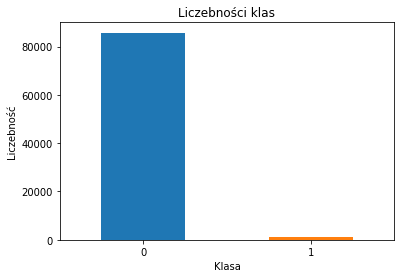

In [12]:
cln_data["Disbursed"].value_counts().plot.bar(x = cln_data["Disbursed"].unique(), y = cln_data["Disbursed"].value_counts().values, rot=0)
plt.xlabel('Klasa' )
plt.ylabel("Liczebność")
plt.title("Liczebności klas")
plt.savefig('czy_wyplacono.png')

## UWAGA: zbior jest niezbalansowany, mamy bardzo malo wyplaconych (1) - i duzo niewyplaconych (0)

In [53]:
cln_data_skosnosc=cln_data
# skosnosc 
cln_data_skosnosc.skew(axis = 0, skipna = True) 

Monthly_Income           59.933316
Loan_Amount_Applied       0.787786
Loan_Tenure_Applied       0.264624
Existing_EMI              1.388757
Var5                      0.760606
Loan_Amount_Submitted     0.941695
Loan_Tenure_Submitted    -0.843323
Interest_Rate             1.430301
Processing_Fee            2.680109
EMI_Loan_Submitted        2.754955
Var4                      0.221128
Disbursed                 8.085500
Lead_Creation_year        0.000000
DOB_year                  3.720653
AGE_APPL                 -3.720653
Empl_Name_len             0.311321
dtype: float64

## UWAGA: stwierdzilem ze nie bede zgadywal i standaryzowal zbioru zmiennych 'na piechote' - pozniej uzyje StandardScalera

## korelacje

In [13]:
correlations = abs(cln_data.corr()["Disbursed"]).sort_values(ascending = False)
correlations.to_frame().head(11)

,Disbursed
Disbursed,1.000000
Var5,0.117146
Interest_Rate,0.092410
EMI_Loan_Submitted,0.049190
Loan_Amount_Submitted,0.043124
Loan_Tenure_Applied,0.037109
Var4,0.036697
Processing_Fee,0.033229
Loan_Amount_Applied,0.032846
Empl_Name_len,0.030418


## wrzucam na wykres wysokie korelacje

/home/kodolamacz/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


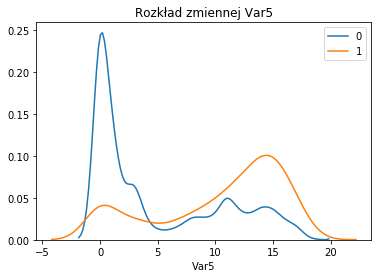

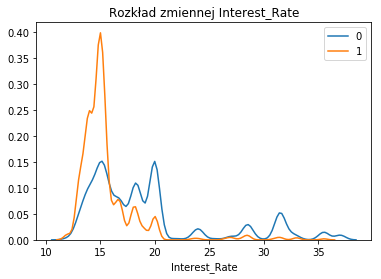

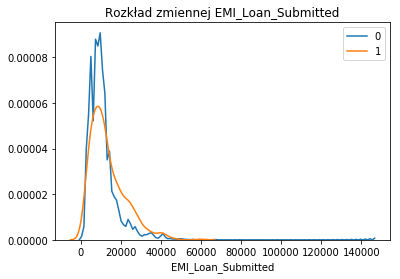

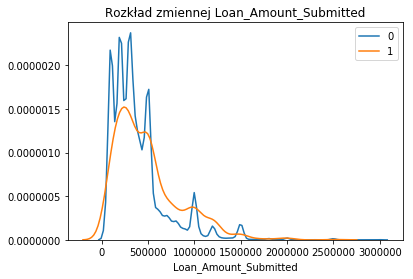

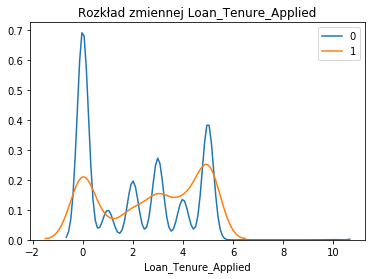

In [12]:
# target_split_plot(cln_data, 'prognozowana', 'wskaznik_zaakceptowanych')

def wykres_zaleznosci(target,zmienna_x):
    target_0 = cln_data[cln_data[target] == 0]
    target_1 = cln_data[cln_data[target] == 1]
    sns.distplot(target_0[target_0[zmienna_x].notnull()][zmienna_x], label = '0', hist = False)
    sns.distplot(target_1[target_1[zmienna_x].notnull()][zmienna_x], label = '1', hist = False)
    plt.legend()
    plt.title("Rozkład zmiennej " + str(zmienna_x))
    plt.show()

wykres_zaleznosci("Disbursed","Var5")
wykres_zaleznosci("Disbursed","Interest_Rate")
wykres_zaleznosci("Disbursed","EMI_Loan_Submitted")
wykres_zaleznosci("Disbursed","Loan_Amount_Submitted")
wykres_zaleznosci("Disbursed","Loan_Tenure_Applied")


## przygotowanie danych pod modelowanie

In [19]:
# Podział na X i Y; Y - Czy wyplacono + na wszelki wypadek ID
X = cln_data.drop(["Disbursed","ID"], 1)
Y = cln_data[["ID","Disbursed"]]
# usuwam datetimey, usuwam zmienne kategoryczne ktore maja bardzo duzo roznych wartosci i sa nisko skorelowane ze zmienna objasniana
del X["DOB"]
del X["Lead_Creation_Date"]
del X["Employer_Name"]

### ustawiam seed dla powtarzalnosci przyszlych przeliczen

In [20]:
seed = 43

In [21]:
X.head()

,Gender,City,Monthly_Income,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Salary_Account,Mobile_Verified,Var5,Var1,Loan_Amount_Submitted,Loan_Tenure_Submitted,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Filled_Form,Device_Type,Var2,Source,Var4,Lead_Creation_year,DOB_year,AGE_APPL,Empl_Name_len
0,Female,Delhi,20000,300000.0,5.0,0.0,HDFC Bank,N,0,HBXX,NaN,NaN,NaN,NaN,NaN,N,Web-browser,G,S122,1,2015,1978,37,7
1,Male,Mumbai,35000,200000.0,2.0,0.0,ICICI Bank,Y,13,HBXA,200000.0,2.0,13.25,NaN,6762.9,N,Web-browser,G,S122,3,2015,1985,30,35
2,Male,Panchkula,22500,600000.0,4.0,0.0,State Bank of India,Y,0,HBXX,450000.0,4.0,NaN,NaN,NaN,N,Web-browser,B,S143,1,2015,1981,34,23
3,Male,Saharsa,35000,1000000.0,5.0,0.0,State Bank of India,Y,10,HBXX,920000.0,5.0,NaN,NaN,NaN,N,Web-browser,B,S143,3,2015,1987,28,16
4,Male,Bengaluru,100000,500000.0,2.0,25000.0,HDFC Bank,Y,17,HBXX,500000.0,2.0,NaN,NaN,NaN,N,Web-browser,B,S134,3,2015,1984,31,20


In [22]:
# one hot encoding - kategoryzajca wszystkich zmiennych w ktorych mamy opisowa dziedzine wartosci -> do kolumn
X = pd.get_dummies(X, sparse=True)
columns = list(X.columns)

In [23]:
X.head()

,Monthly_Income,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Var5,Loan_Amount_Submitted,Loan_Tenure_Submitted,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Var4,Lead_Creation_year,DOB_year,AGE_APPL,Empl_Name_len,Gender_Female,Gender_Male,City_ADIPUR,City_AHMEDB,City_AMALSAD,City_ANJAR,City_Abohar,City_Adilabad,City_Agartala,City_Agra,City_Ahmedabad,City_Ahmednagar,City_Aizawl,City_Ajmer,City_Akola,City_Alappuzha,City_Aligarh,City_Allahabad,City_Alleppey,City_Almora,City_Aluva,City_Alwar,City_Amareli,City_Ambala,City_Ambedkar Nagar,City_Ambikapur,City_Ambur,City_Amravati,City_Amreli,City_Amritsar,City_Anand,City_Anantapur,City_Anantnag,City_Andman & Nicobar,City_Angul,City_Anjaw,City_Ankleshwar,City_Anuppur,City_Araria,City_Ariyalur,City_Asansol,City_Ashoknagar,City_Auraiya,City_Aurangabad,City_Azamgarh,City_BAJWA,City_BARDOLI,City_BHACHAU,City_BHILAD,City_BILIMORA,City_Badaun,City_Baddi,City_Bagalkote,City_Bageshwar,City_Bagpat,City_Bahadurgarh,City_Bahraich,City_Baksa,City_Balaghat,City_Balasore,City_Baleswar,City_Ballia,City_Banaskantha,City_Banaskhantha,City_Banda,City_Bandipore,City_Banka,City_Bankura,City_Banswara,City_Barabanki,City_Baramati,City_Baramulla,City_Baran,City_Bardhaman,City_Bareilly,City_Bargarh,City_Barmer,City_Barnala,City_Barpeta,City_Barwani,City_Bastar,City_Basti,City_Bathinda,City_Beawar,City_Beed,...,Salary_Account_GIC Housing Finance Ltd,Salary_Account_HDFC Bank,Salary_Account_HSBC,Salary_Account_ICICI Bank,Salary_Account_IDBI Bank,Salary_Account_ING Vysya,Salary_Account_India Bulls,Salary_Account_Indian Bank,Salary_Account_Indian Overseas Bank,Salary_Account_IndusInd Bank,Salary_Account_Industrial And Commercial Bank Of China Limited,Salary_Account_J&K Bank,Salary_Account_Karnataka Bank,Salary_Account_Karur Vysya Bank,Salary_Account_Kerala Gramin Bank,Salary_Account_Kotak Bank,Salary_Account_Lakshmi Vilas bank,Salary_Account_Oriental Bank of Commerce,Salary_Account_Punjab & Sind bank,Salary_Account_Punjab National Bank,Salary_Account_Saraswat Bank,Salary_Account_South Indian Bank,Salary_Account_Standard Chartered Bank,Salary_Account_State Bank of Bikaner & Jaipur,Salary_Account_State Bank of Hyderabad,Salary_Account_State Bank of India,Salary_Account_State Bank of Indore,Salary_Account_State Bank of Mysore,Salary_Account_State Bank of Patiala,Salary_Account_State Bank of Travancore,Salary_Account_Syndicate Bank,Salary_Account_Tamil Nadu Mercantile Bank,Salary_Account_The Ratnakar Bank Ltd,Salary_Account_UCO Bank,Salary_Account_Union Bank of India,Salary_Account_United Bank of India,Salary_Account_Vijaya Bank,Salary_Account_Yes Bank,Mobile_Verified_N,Mobile_Verified_Y,Var1_HAVC,Var1_HAXA,Var1_HAXB,Var1_HAXC,Var1_HAXF,Var1_HAXM,Var1_HAYT,Var1_HAZD,Var1_HBXA,Var1_HBXB,Var1_HBXC,Var1_HBXD,Var1_HBXH,Var1_HBXX,Var1_HCXD,Var1_HCXF,Var1_HCXG,Var1_HCYS,Var1_HVYS,Filled_Form_N,Filled_Form_Y,Device_Type_Mobile,Device_Type_Web-browser,Var2_A,Var2_B,Var2_C,Var2_D,Var2_E,Var2_F,Var2_G,Source_S122,Source_S123,Source_S124,Source_S125,Source_S127,Source_S129,Source_S130,Source_S133,Source_S134,Source_S135,Source_S136,Source_S137,Source_S138,Source_S139,Source_S140,Source_S141,Source_S143,Source_S144,Source_S150,Source_S151,Source_S153,Source_S154,Source_S155,Source_S156,Source_S157,Source_S158,Source_S159,Source_S160,Source_S161,Source_S162
0,20000,300000.0,5.0,0.0,0,NaN,NaN,NaN,NaN,NaN,1,2015,1978,37,7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,35000,200000.0,2.0,0.0,13,200000.0,2.0,13.25,NaN,6762.9,3,2015,1985,30,35,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [24]:
# imputacja - wybralem dosc czesto stosowany sposob dla NaN/None, wypelnianie mediana
imputer = Imputer(strategy = "median")
imputer.fit(X)
X = imputer.transform(X) 

In [25]:
# split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)    

In [26]:
 # skalowanie zmiennych - uzywam StandardScalera
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)

In [27]:
# dolaczenie nazw kolumn
X_train = pd.DataFrame(data = X_train, columns = columns)
X_test = pd.DataFrame(data = X_test, columns = columns)

# przystepuje do modelowania
## by zaprezentowac zrozumienie - niestety przy ograniczonych zasobach sprzetowych - wybralem 3 podejscia (najczesciej stosowane obecnie): 1 LOGIT (bardziej klasycznie) oraz 2 i 3 - XGB i XGB z cv i gridsearchem.

# Model 1 - logit

In [29]:
logit = LogisticRegression(C = 0.01, penalty='l1', verbose = True)
logit.fit(X_train, Y_train['Disbursed'])

probs_logit = logit.predict_proba(X_test)
preds_logit = probs_logit[:,1]
fpr, tpr, threshold = metrics.roc_curve(Y_test['Disbursed'], preds_logit)
roc_auc_logit = metrics.auc(fpr, tpr)

f'Model 1 - wspolczynik AUC :  {roc_auc_logit}'

[LibLinear]

'Model 1 - wspolczynik AUC :  0.768928702276316'

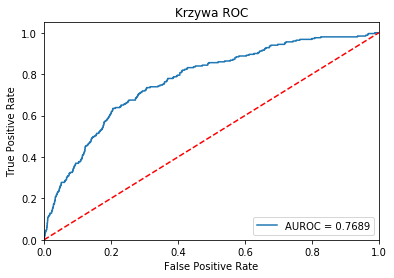

In [30]:
rysuj_roc(fpr,tpr,roc_auc_logit)

# Model 2 - xgboost bez gridsearcha/cv

In [32]:
# bazowy model xgboost
model1 = xgb.XGBClassifier(n_estimators=200,verbose = True, nthread=-1, seed = 1000)
model1_fitted = model1.fit(X_train, Y_train['Disbursed'], verbose=True)
# Krzywa ROC
probabilities = model1_fitted.predict_proba(X_test)
predictions = probabilities[:,1]
fpr, tpr, threshold = metrics.roc_curve(Y_test['Disbursed'], predictions)
roc_auc_xgb = metrics.auc(fpr, tpr)

In [33]:
roc_auc_xgb

0.8461313631090963

In [34]:
f'Model 2 xgboost - wspolczynik AUC :  {roc_auc_xgb}'

'Model 2 xgboost - wspolczynik AUC :  0.8461313631090963'

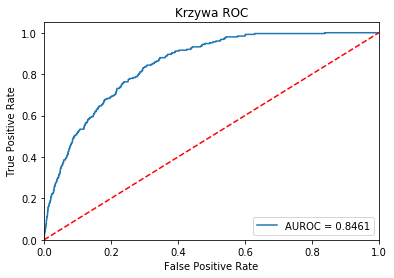

In [35]:
rysuj_roc(fpr,tpr,roc_auc_xgb)

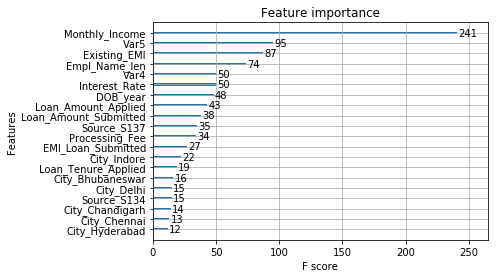

In [70]:
xgb.plot_importance(model1_fitted, max_num_features = 20, importance_type='weight')


# Model 3 - gridsearch z cv dla xgboost

In [36]:
cv_params = { 'max_depth': [5, 8, 2], 'min_child_weight': [0.5, 1.5],  'colsample_bytree': [0.5, 0.7, 0.9], 'subsample':  [0.5, 0.7, 0.9]  }
ind_params = {'n_estimators': 10,'objective': 'binary:logistic', 'seed': 100, 'learning_rate': 0.02 }
optimized_XGB = GridSearchCV(xgb.XGBClassifier(**ind_params), 
                            cv_params, 
                             scoring = 'roc_auc', cv = 2, n_jobs = -1, verbose = True) 
optimized_XGB.fit(X_train, Y_train['Disbursed'])

Fitting 2 folds for each of 54 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  4.7min finished


GridSearchCV(cv=2, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.02, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=10,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=100,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [5, 8, 2], 'min_child_weight': [0.5, 1.5], 'colsample_bytree': [0.5, 0.7, 0.9], 'subsample': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=True)

In [37]:
optimized_XGB.best_params_

{'colsample_bytree': 0.5,
 'max_depth': 8,
 'min_child_weight': 1.5,
 'subsample': 0.9}

## crossvalidation

In [38]:
#  Dla cross validacji wybieramy większą liczbę iteracji i mniejszy learning rate - 
#     grid search z tak małym learning rate nie wchodził w grę, ze względu na ograniczone zasoby obliczeniowe
#     Parametry do crossvalidacji
params = {'learning_rate': 0.009, 'random_state':1000, 'subsample': 0.5, 'colsample_bytree': 0.7, 
             'objective': 'binary:logistic', 'max_depth':8, 'min_child_weight':1.5}

# transformacja do wymaganego formatu
xgdmat = xgb.DMatrix(X_train, Y_train['Disbursed'])


/home/kodolamacz/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/kodolamacz/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [39]:
# fitowanie cv
crosv = xgb.cv(params = params, dtrain = xgdmat, num_boost_round = 20, nfold = 2, metrics = ['auc'],
               early_stopping_rounds = 20, verbose_eval=True) 

[0]	train-auc:0.750039+0.001348	test-auc:0.746256+0.0050395
[1]	train-auc:0.774401+0.0080785	test-auc:0.762377+0.0006655
[2]	train-auc:0.777603+0.004416	test-auc:0.762861+0.0017975
[3]	train-auc:0.784483+0.000546	test-auc:0.773154+0.0093095
[4]	train-auc:0.786337+0.0002975	test-auc:0.774004+0.0111045
[5]	train-auc:0.786272+0.0002325	test-auc:0.773934+0.0110335
[6]	train-auc:0.795968+0.008574	test-auc:0.780067+0.0172505
[7]	train-auc:0.799078+0.005131	test-auc:0.782897+0.013999
[8]	train-auc:0.799389+0.0048225	test-auc:0.782664+0.0141475
[9]	train-auc:0.803074+0.0071275	test-auc:0.7881+0.018656
[10]	train-auc:0.802559+0.0064335	test-auc:0.787857+0.0180125
[11]	train-auc:0.803862+0.0079235	test-auc:0.789426+0.019335
[12]	train-auc:0.80407+0.006946	test-auc:0.789532+0.0182915
[13]	train-auc:0.807136+0.0032035	test-auc:0.791826+0.0162
[14]	train-auc:0.808376+0.003177	test-auc:0.791956+0.0154365
[15]	train-auc:0.816028+0.004459	test-auc:0.799625+0.007795
[16]	train-auc:0.816307+0.0047475	te

In [40]:
crosv

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.750039,0.001348,0.746256,0.005039
1,0.774401,0.008079,0.762377,0.000665
2,0.777603,0.004416,0.762861,0.001798
3,0.784483,0.000546,0.773154,0.009310
4,0.786337,0.000298,0.774004,0.011104
5,0.786272,0.000233,0.773934,0.011033
6,0.795968,0.008574,0.780067,0.017251
7,0.799078,0.005131,0.782897,0.013999
8,0.799389,0.004823,0.782664,0.014147
9,0.803074,0.007128,0.788100,0.018656


### po optymalizacji

In [41]:
# Zoptymalizowany xgboost
model_optimized = xgb.XGBClassifier(n_estimators=100,verbose = True, nthread=-1, seed = 1000, silent = False,
                                    learning_rate =  0.009, subsample = 0.5, colsample_bytree = 0.7, 
                                     min_child_weight = 1.5, max_depth = 8)
model_optimized_fit = model_optimized.fit(X_train, Y_train['Disbursed'], verbose=True)


In [42]:
probabilities_opt = model_optimized_fit.predict_proba(X_test)
predictions_opt = probabilities_opt[:,1]
fpr, tpr, threshold = metrics.roc_curve(Y_test['Disbursed'], predictions_opt)
roc_auc_xgb_opt = metrics.auc(fpr, tpr)

In [43]:
roc_auc_xgb_opt

0.8201756018536401

In [44]:
f'Model 3 xgboost+cv+grid - wspolczynik AUC :  {roc_auc_xgb_opt}'

'Model 3 xgboost+cv+grid - wspolczynik AUC :  0.8201756018536401'

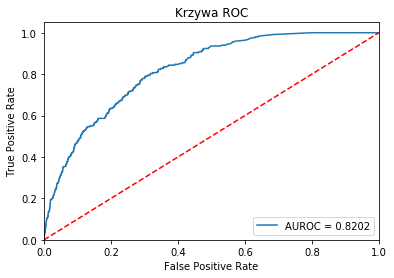

In [45]:
rysuj_roc(fpr,tpr,roc_auc_xgb_opt)

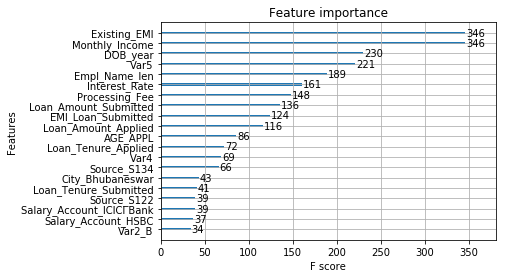

In [46]:
xgb.plot_importance(model_optimized_fit, max_num_features = 20, importance_type='weight')


# PODSUMOWANIE

### Najlepszym modelem jest Model 2 - xgboost.
### Byc moze przy wiekszej optymalizacji Model 3 (xgb + opt) bylby lepszy (tak zamierzalem). Porownanie AUC ponizej:

### model 2 mocno zalkezy od zmiennej Monthly_income, podczas gdy model 3 ma wiecej silnych predyktorow

In [61]:
podsumwoanie = {'Model 1 logit':roc_auc_logit,
                'Model 2 xgb':roc_auc_xgb,
                'Model 3 xgb opt':roc_auc_xgb_opt        
                }

In [68]:
podsumowanie_df = pd.DataFrame.from_dict(podsumwoanie, orient='index', columns = ['AUC'])

In [69]:
podsumowanie_df

,AUC
Model 1 logit,0.768929
Model 2 xgb,0.846131
Model 3 xgb opt,0.820176


### __________________________ appendix - wykresy wagi dla xgb i xgb opt

JAKIE ZMIENNE W XGB (model 2 i 3) ?
model 2


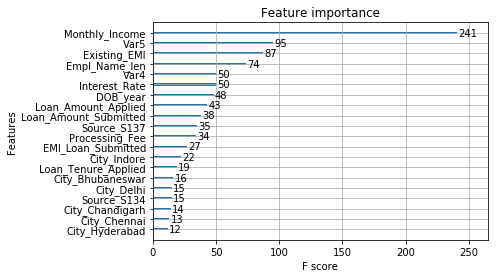

In [73]:
print('JAKIE ZMIENNE W XGB (model 2 i 3) ?')
print('model 2')
xgb.plot_importance(model1_fitted, max_num_features = 20, importance_type='weight')


model 3


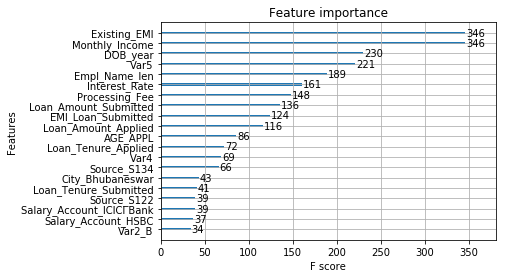

In [72]:
print('model 3')
xgb.plot_importance(model_optimized_fit, max_num_features = 20, importance_type='weight') 